In [77]:
# Pasang LangChain Community (buat fitur tambahan untuk AI/LLM)
!pip install langchain_community

# Pasang Replicate (buat pakai model AI online)
!pip install replicate

In [78]:
# Ambil API token dari Colab dan simpan supaya Replicate bisa pakai
from google.colab import userdata
import os

token = userdata.get("api_token")
os.environ["REPLICATE_API_TOKEN"] = token

In [79]:
# Hubungkan ke model AI online (Granite 8B) lewat Replicate
from langchain_community.llms import Replicate

llm = Replicate(
    model="ibm-granite/granite-3.3-8b-instruct",
)

In [80]:
!pip install pandas

# Pasang/upgrade LangChain dan ekstensi komunitasnya, plus Replicate untuk akses model AI online
!pip install -U langchain langchain-community langchain-experimental replicate

# Load Data

In [81]:
import pandas as pd

df = pd.read_csv("spam.csv")
df.head()

,Teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,1
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,1
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",1
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",1
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,1


In [82]:
# cek isi unik dari kolom
print(df['label'].unique())

[1 0]


In [83]:
## check data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Teks    1143 non-null   object
 1   label   1143 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 18.0+ KB


In [84]:
from langchain_experimental.agents.agent_toolkits.pandas.base import (
    create_pandas_dataframe_agent  # Import fungsi buat bikin agent untuk DataFrame
)

# Buat agent yang bisa menjawab pertanyaan tentang DataFrame pakai LLM
agent = create_pandas_dataframe_agent(
    llm=llm,                       # Model AI yang dipakai
    df=df,                         # DataFrame pandas yang ingin dianalisis
    verbose=True,                  # Tampilkan log interaksi
    allow_dangerous_code=True,     # Mengizinkan eksekusi kode Python langsung (REPL)
)

# EDA

## Label Distribution

<Axes: xlabel='label'>

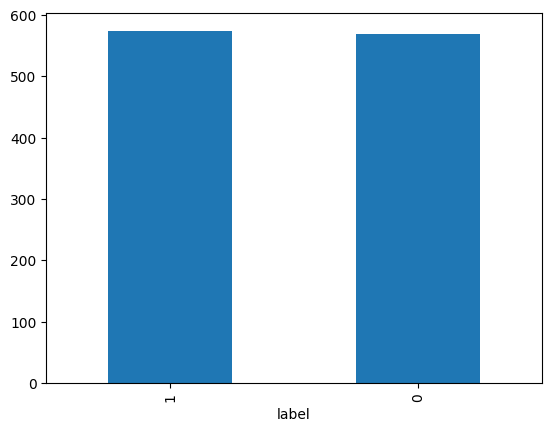

In [85]:
df['label'].value_counts().plot(kind='bar')

__Insight:__
* Diagram batang menunjukkan bahwa jumlah data untuk kedua kelas, yaitu "spam" (label 1) dan "non-spam" (label 0), memiliki jumlah yang hampir sama.

In [86]:
!pip install Sastrawi

In [87]:
import numpy as np
import pandas as pd
from string import punctuation
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

## WordCloud
WordCloud bikin gambar dari teks, kata yang sering muncul jadi besar, kata jarang muncul kecil.

In [88]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize

import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### Spam

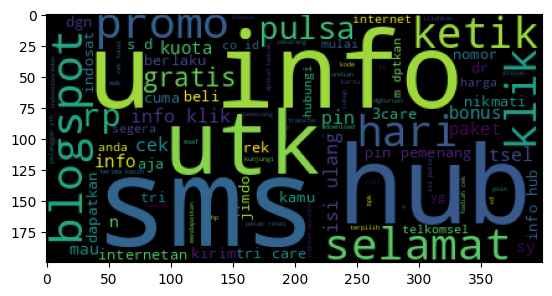

In [89]:
# create stopword list
factory = StopWordRemoverFactory()
stopwords = factory.get_stop_words()
# create punctuation list
punctuation_list = list(punctuation)
# combine stopwords and punctuation
sw_punct = stopwords + punctuation_list

## semua teks dijadikan 1 paragraf
all_teks = " ".join(df[df.label==1].Teks.values)  #jadikan 1 paragraf
all_teks = word_tokenize(all_teks.lower())        #jadikan huruf kecil, lalu ditokenisasi
all_teks = [item for item in all_teks if item not in sw_punct] #remove stopwords
all_teks = " ".join(all_teks)                     #disatukan ulang

wordclound = WordCloud().generate(all_teks)
plt.imshow(wordclound);

### Non Spam

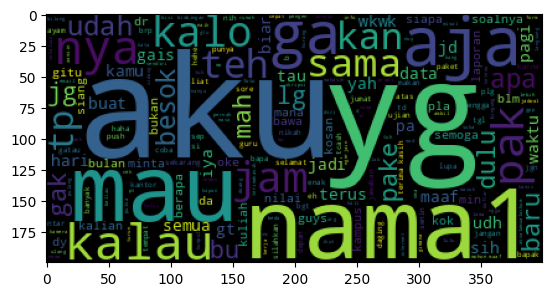

In [90]:
## semua teks dijadikan 1 paragraf
all_teks = " ".join(df[df.label==0].Teks.values)  #jadikan 1 paragraf
all_teks = word_tokenize(all_teks.lower())        #jadikan huruf kecil, lalu ditokenisasi
all_teks = [item for item in all_teks if item not in sw_punct] #remove stopwords
all_teks = " ".join(all_teks)                     #disatukan ulang

wordclound = WordCloud().generate(all_teks)
plt.imshow(wordclound);

# Data Preprocessing

In [91]:
## data yang akan diubah menjadi vektor
X = df['Teks']

## label
y = df['label']

## Word Embedding by TF-IDF

In [92]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [93]:
embedding_model  = TfidfVectorizer(stop_words=sw_punct,ngram_range=(1,1))
embedding_matrix = embedding_model.fit_transform(X)

X_embedding = pd.DataFrame(embedding_matrix.toarray())

In [94]:
X_embedding.shape

(1143, 4857)

# Data Splitting

In [95]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_embedding,y,test_size=0.2,
                                                    random_state=1,stratify=y)

# Modeling

In [96]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

parameter = {
    'C' : [10,1,0.1, 0.001, 0.001],
    'fit_intercept':[True,False]
}

In [97]:
model = GridSearchCV(LogisticRegression(),parameter,verbose=1)
model.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [10, 1, 0.1, 0.001, 0.001],
                         'fit_intercept': [True, False]},
             verbose=1)

In [98]:
from sklearn.metrics import classification_report

def classification_score(model,X,y):
    y_predicted = model.predict(X)
    print(classification_report(y,y_predicted))

classification_score(model,X_test,y_test)

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       114
           1       0.98      0.97      0.97       115

    accuracy                           0.97       229
   macro avg       0.97      0.97      0.97       229
weighted avg       0.97      0.97      0.97       229



# Backtest

In [99]:
# text_1 = ["[PROMO] Beli paket Flash mulai 1GB di MY TELKOMSEL APP dpt EXTRA kuota 2GB 4G LTE dan EXTRA nelpon hingga 100mnt/1hr. Buruan, cek  di tsel.me/mytsel1 S&K"]
# text_2 = ["Besok kita masuk kuliah jam 07:30 di gedung A."]
# text_3 = ["""TUTUP CC & KTA ANDA, KAMI BANTU DNGN 2 SOLUSI:
#              1. CICIL TETAP BUNGA 2%
#              2. DISC PELUNASAN 30% S/D 60%
#              CLEAR BI & LEGAL
#              INFO :
#              TELP/WA : SARI 085212345678"""]
# text_4 = ["Eh besok kumpulnya jam berapa? soalnya aku harus atur jadwal kerja biar gak bentrok sama kegiatan di kampus"]

In [100]:
# def predict_spam(model,text):
#     ## word embedding
#     text_embedding = embedding_model.transform(text).toarray()

#     ## prediction
#     prediction = model.predict(text_embedding)[0]

#     ## prediction classification
#     if prediction == 1:
#       return 'Spam'
#     else :
#       return 'Non Spam'

In [101]:
# predict_spam(model,text_1)

# LLM - IBM GRANITE

In [104]:
agent.invoke({"input": "classify this if 1=spam, 0=non spam '[PROMO] Beli paket Flash mulai 1GB di MY TELKOMSEL APP dpt EXTRA kuota 2GB 4G LTE dan EXTRA nelpon hingga 100mnt/1hr. Buruan, cek  di tsel.me/mytsel1 S&K'"})



> Entering new AgentExecutor chain...
Thought: The task is to classify a given text as either spam (1) or non-spam (0) based on the provided dataframe. The text to be classified is '[PROMO] Beli paket Flash mulai 1GB di MY TELKOMSEL APP dpt EXTRA kuota 2GB 4G LTE dan EXTRA nelpon hingga 100mnt/1hr. Buruan, cek  di tsel.me/mytsel1 S&K'. 

To proceed, I need to examine the 'Teks' column in the dataframe to understand the characteristics of spam and non-spam entries. I will look for patterns in the text that align with the given example.

Action: python_repl_ast

Action Input:
```python
# Check the 'label' values for the first few rows to infer spam characteristics
print(df['label'][0:5])
```

0    1
1    1
2    1
3    1
4    1
Name: label, dtype: int64
Based on the observation, all the 'label' values from the first few rows are 1, indicating that all these entries are classified as spam. The text to be classified, '[PROMO] Beli paket Flash mulai 1GB di MY TELKOMSEL APP dpt EXTRA kuota 

{'input': "classify this if 1=spam, 0=non spam '[PROMO] Beli paket Flash mulai 1GB di MY TELKOMSEL APP dpt EXTRA kuota 2GB 4G LTE dan EXTRA nelpon hingga 100mnt/1hr. Buruan, cek  di tsel.me/mytsel1 S&K'",
 'output': '1 (spam)'}

In [105]:
agent.invoke({"input": "classify this if 1=spam, 0=non spam 'Eh besok kumpulnya jam berapa? soalnya aku harus atur jadwal kerja biar gak bentrok sama kegiatan di kampus'"})



> Entering new AgentExecutor chain...
Thought: The given dataframe `df` contains rows with 'Teks' and 'label' columns. The 'label' column indicates whether the 'Teks' is spam (1) or not spam (0). The input text is not present in the dataframe, so we cannot directly classify it using the existing labels. We need to create a function to classify new text based on the patterns observed in the existing labels.

Action: python_repl_ast

Action Input:
```python
import pandas as pd

# Assuming df is already defined

# Check existing labels
existing_labels = df['label'].unique()
existing_labels
```

[1 0]The existing labels in the dataframe are 'spam' (1) and 'non-spam' (0). To classify the new text, I will create a function that checks for keywords or patterns similar to those in the spam and non-spam texts.

Action: python_repl_ast

Action Input:
```python
def classify_text(text):
    spam_keywords = ['PROMO', 'hanya', 'Spesial', 'Buruan', 'SKB', '*######', 'hingga']
    non_spam_keywords 

{'input': "classify this if 1=spam, 0=non spam 'Eh besok kumpulnya jam berapa? soalnya aku harus atur jadwal kerja biar gak bentrok sama kegiatan di kampus'",
 'output': "The new text 'Eh besok kumpulnya jam berapa? soalnya aku harus atur jadwal kerja biar gak bentrok sama kegiatan di kampus' is classified as non-spam (0)."}